In [2]:
#Packages and libraries
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import sys, os, re, csv, codecs
import time
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [3]:
#Cleaning Data (substitute, lemmatize and lower)
eng_stopwords = set(stopwords.words("english"))
lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()
color = sns.color_palette()

APPOS = { "aren't" : "are not", "can't" : "cannot", "couldn't" : "could not", "didn't" : "did not", "doesn't" : "does not", "don't" : "do not", "hadn't" : "had not", "hasn't" : "has not", "haven't" : "have not", "he'd" : "he would", "he'll" : "he will", "he's" : "he is", "i'd" : "I would", "i'd" : "I had", "i'll" : "I will", "i'm" : "I am", "isn't" : "is not", "it's" : "it is", "it'll":"it will", "i've" : "I have", "let's" : "let us", "mightn't" : "might not", "mustn't" : "must not", "shan't" : "shall not", "she'd" : "she would", "she'll" : "she will", "she's" : "she is", "shouldn't" : "should not", "that's" : "that is", "there's" : "there is", "they'd" : "they would", "they'll" : "they will", "they're" : "they are", "they've" : "they have", "we'd" : "we would", "we're" : "we are", "weren't" : "were not", "we've" : "we have", "what'll" : "what will", "what're" : "what are", "what's" : "what is", "what've" : "what have", "where's" : "where is", "who'd" : "who would", "who'll" : "who will", "who're" : "who are", "who's" : "who is", "who've" : "who have", "won't" : "will not", "wouldn't" : "would not", "you'd" : "you would", "you'll" : "you will", "you're" : "you are", "you've" : "you have", "'re": " are","wasn't": "was not", "we'll":" will", "didn't": "did not"
}

def clean(comment):
    comment = comment.lower()
    # remove new line character
    comment=re.sub('\\n','',comment)
    # remove ip addresses
    comment=re.sub('\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', '', comment)
    # remove usernames
    comment=re.sub('\[\[.*\]', '', comment)
    # split the comment into words
    words = tokenizer.tokenize(comment)
    # replace that's to that is by looking up the dictionary
    words=[APPOS[word] if word in APPOS else word for word in words]
    # replace variation of a word with its base form
    words=[lem.lemmatize(word, "v") for word in words]
    # eliminate stop words
    words = [w for w in words if not w in eng_stopwords]
    # now we will have only one string containing all the words
    clean_comment=" ".join(words)
    # remove all non alphabetical characters
    clean_comment=re.sub("\W+"," ",clean_comment)
    clean_comment=re.sub("  "," ",clean_comment)
    return (clean_comment)

In [4]:
#trial sentence
clean("maybe this does not make sense")

'maybe make sense'

In [5]:
start = time.time()

#reading data
print('Reading the dataset...')
train = pd.read_csv('train.csv', encoding='latin-1')
test = pd.read_csv('test.csv', encoding='latin-1')
submission = pd.read_csv('sample_submission.csv')

Reading the dataset...


c:\users\shame\appdata\local\programs\python\python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


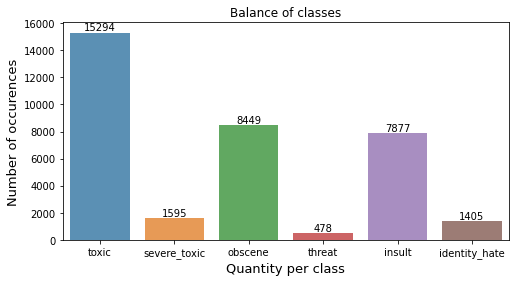

In [6]:
# visualizing class frequency

column = train.iloc[:,2:].sum()
# plot
plt.figure(figsize=(8,4))
ax = sns.barplot(column.index, column.values, alpha=0.8)
plt.title("Balance of classes")
plt.ylabel('Number of occurences', fontsize=13)
plt.xlabel('Quantity per class', fontsize=13)
# adding the text labels
rects = ax.patches
labels = column.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

In [7]:
#cleaning dataset
print('Cleaning the dataset...')
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"].apply(lambda comment: clean(comment))
list_sentences_test = test["comment_text"].apply(lambda comment: clean(comment))

Cleaning the dataset...


In [8]:
#cleaned data
print(list_sentences_train.head())

0    explanationwhy edit make username hardcore met...
1    d aww match background colour I am seemingly s...
2    hey man I am really try edit war it is guy con...
3     morei cannot make real suggestions improvemen...
4               sir hero chance remember page that is 
Name: comment_text, dtype: object


In [9]:
#converting sentences to tokens
print('Tokenizing the cleaned sentences...')
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)


Tokenizing the cleaned sentences...


In [10]:
#tokenized data
list_tokenized_train

[[5,
  12,
  564,
  3724,
  9592,
  668,
  74,
  1865,
  3,
  9593,
  5343,
  2065,
  437,
  70,
  1071,
  13161,
  2381,
  14,
  22,
  3,
  42,
  275,
  6,
  2,
  89,
  8,
  31,
  2256],
 [406,
  14348,
  937,
  440,
  2294,
  8,
  31,
  3755,
  799,
  24,
  6,
  735,
  2777,
  854,
  517,
  6891,
  121],
 [334,
  314,
  8,
  31,
  83,
  61,
  5,
  155,
  29,
  7,
  262,
  1928,
  42,
  402,
  57,
  6,
  5,
  273,
  6,
  2,
  71,
  291,
  687,
  619,
  368],
 [90,
  12,
  243,
  1252,
  1793,
  521,
  63,
  2147,
  414,
  3566,
  343,
  8125,
  17,
  75,
  34,
  33,
  4538,
  1255,
  687,
  1868,
  234,
  687,
  236,
  414,
  1559,
  15,
  216,
  67,
  3786,
  687,
  229,
  75,
  35,
  14,
  119,
  20,
  269,
  191,
  4508,
  1,
  181,
  471,
  34,
  1520,
  2495,
  590,
  29,
  7,
  54,
  402,
  365,
  3026,
  4,
  51,
  1,
  3005,
  3523],
 [1471, 2969, 827, 444, 2, 135, 7],
 [2298, 53, 10, 1013, 53, 13, 13, 6],
 [1599, 1728, 239, 45],
 [141, 2961, 1, 74, 14, 22, 3, 245],
 [200,
  9

In [11]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [12]:
#padding data to fill in the spaces in array as different sentences have different no. of words
print('Padding the cleaned and tokenized sentences...')
maxlen = 100
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

Padding the cleaned and tokenized sentences...


In [13]:
#splitting our data into training and testing with a 0.9 and 0.1 split ratio
print('Splitting Preprocessed data...')
x_train, x_test, y_train, y_test = train_test_split(X_t, y, test_size= 0.1, random_state=0)

Splitting Preprocessed data...


In [14]:
#our new training data - feautres (clean, tokeninzed and padded)
print('Training Data - Feautures set')
x_train

Training Data - Feautures set


array([[    0,     0,     0, ...,   221,   220,    24],
       [    0,     0,     0, ...,  4002,  2869,    43],
       [    0,     0,     0, ...,    22,   311, 11970],
       ...,
       [    0,     0,     0, ...,    51, 14685,     6],
       [    0,     0,     0, ...,     1,    41,     4],
       [    0,     0,     0, ...,   153,    93,   113]])

In [15]:
#our new training data - outputs (clean, tokeninzed and padded)
print('Training Data - Outputs')
y_train

Training Data - Outputs


array([[0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [16]:
inp = Input(shape=(maxlen, ))

# size of the vector space
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

output_dimention = 60
x = LSTM(output_dimention, return_sequences=True,name='lstm_layer')(x)
# reduce dimention
x = GlobalMaxPool1D()(x)
# disable 10% precent of the nodes
x = Dropout(0.1)(x)
# pass output through a RELU function
x = Dense(50, activation="relu")(x)
# another 10% dropout
x = Dropout(0.1)(x)
# pass the output through a sigmoid layer, since 
# Since it is multilabel classification 
x = Dense(6, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=x)
# we use binary_crossentropy because of binary classification
# optimise loss by Adam optimiser
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Training Model...')
start_fitting = time.time()
batch_size = 100
epochs = 5
hist = model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
fitting_model_time = time.time()
print('Training Model took: ', fitting_model_time - start_fitting)


Training Model...
Epoch 1/5
1149/1149 [==============================] - 118s 102ms/step - loss: 0.1073 - accuracy: 0.9092 - val_loss: 0.0534 - val_accuracy: 0.9943
Epoch 2/5
1149/1149 [==============================] - 115s 100ms/step - loss: 0.0501 - accuracy: 0.9905 - val_loss: 0.0507 - val_accuracy: 0.9943
Epoch 3/5
1149/1149 [==============================] - 118s 102ms/step - loss: 0.0439 - accuracy: 0.9916 - val_loss: 0.0499 - val_accuracy: 0.9943
Epoch 4/5
1149/1149 [==============================] - 119s 103ms/step - loss: 0.0386 - accuracy: 0.9910 - val_loss: 0.0528 - val_accuracy: 0.9943
Epoch 5/5
1149/1149 [==============================] - 114s 99ms/step - loss: 0.0341 - accuracy: 0.9818 - val_loss: 0.0564 - val_accuracy: 0.9939
Training Model took:  583.8794741630554


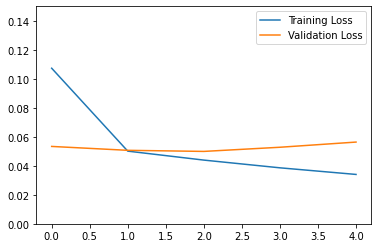

In [52]:
# plt.plot(hist.history['loss'], hist.history['val_loss'], label = "line 1")
# plt.plot(hist.history['val_loss'], hist.history['loss'], label = "line 2")
# plt.legend()
plt.plot(hist.history['loss'],label='Training Loss')
plt.plot(hist.history['val_loss'],label='Validation Loss')
plt.ylim(ymin=0,ymax=0.15)
plt.legend()
plt.show()
plt.show()

In [17]:
#Predicting using test data
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5) 


In [18]:
#Accuracy
from sklearn.metrics import accuracy_score
print("General Accuracy for Test data is {:.3%}".format(accuracy_score(y_test,y_pred)))


General Accuracy for Test data is 91.597%


In [19]:
#precision
from sklearn.metrics import precision_score
print("Precision for test data is:")
precision_score(y_test, y_pred, average='micro')

Precision for test data is:


0.7916803144448084

In [20]:
#Class-wise classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.80      0.76      0.78      1531
           1       0.60      0.25      0.35       161
           2       0.84      0.77      0.81       858
           3       0.00      0.00      0.00        43
           4       0.75      0.62      0.68       813
           5       0.55      0.29      0.38       147

   micro avg       0.79      0.68      0.73      3553
   macro avg       0.59      0.45      0.50      3553
weighted avg       0.77      0.68      0.72      3553
 samples avg       0.07      0.06      0.06      3553



c:\users\shame\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\shame\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\shame\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [21]:
#Class-wise confusion matrix
from sklearn.metrics import multilabel_confusion_matrix
print(multilabel_confusion_matrix(y_test, y_pred))


[[[14145   282]
  [  368  1163]]

 [[15770    27]
  [  121    40]]

 [[14976   124]
  [  194   664]]

 [[15915     0]
  [   43     0]]

 [[14977   168]
  [  306   507]]

 [[15776    35]
  [  104    43]]]
